In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 5. Реализуйте генератор случайных квадратичных функций $n$ переменных с числом обусловленности $k$.

## Вспомогательные функции

In [2]:
from tqdm import tqdm

# Функция проверки числа обусловленности у сгенерированных матриц 
def check_generate_matrix(f_generator, g = 900):
    n = 2       # Размерность сгенерированной матрицы
    k = 1000    # Необходимое число обусловленности сгенерированной матрицы

    #g          # Число испытаний
    eps = 1e-3  # Допустимая погрешность в числе обусловленности

    x = np.arange(0, g, 1)
    y = np.zeros(g)

    number_of_wrong = 0
    for i in tqdm(range(g)):
        y[i] = np.linalg.cond(f_generator(n, k, eps=eps))
        if(np.abs(y[i] - k) > eps):
            number_of_wrong += 1

    print("Количество неправильных матриц:", number_of_wrong)
    # print(y)

    plt.plot(x, y)
    plt.show()

## Простой способ, сохраняет только коэффициенты при $x_i^2$ (на главной диагонали)

Этот способ генерирует диагональную матрицу, такую, что частное максимального и минимального элемента равно $k$ 
$$\frac{max(A)}{min(A)} = k$$

Так как матрица диагональная - собственные числа такой матрицы равны элементам на диагонали, сингулярные числа совпадают с собственными, а отношение максимального сингулярного числа к минимальному - один из способов вычислить число обусловленности матрицы: 2-norm (largest sing. value).

In [3]:
def generate_random_matrix_simple(n, k, eps):
    # eps -- неиспользуемое значение, необходимо для соответствия другим функциям генераторам
    A = np.zeros((n, n))
    A[0,0] = np.random.uniform(low=-1, high=1)
    A[n-1, n-1] = A[0,0] / k

    for i in range(0, n-2):
        A[i, i] = np.random.uniform(low=A[0,0], high=A[n-1, n-1])

    return A

# облегченная версия generate_random_matrix_simple
def generate_random_vector_simple(n, k):
    global v
    v = np.zeros((n))
    v[0] = np.random.uniform(low=-1, high=1)
    v[n-1] = v[0] / k

    for i in range(0, n-2):
        v[i] = np.random.uniform(low=v[0], high=v[n-1])

    return v

100%|██████████| 900/900 [00:00<00:00, 16987.10it/s]


Количество неправильных матриц: 0


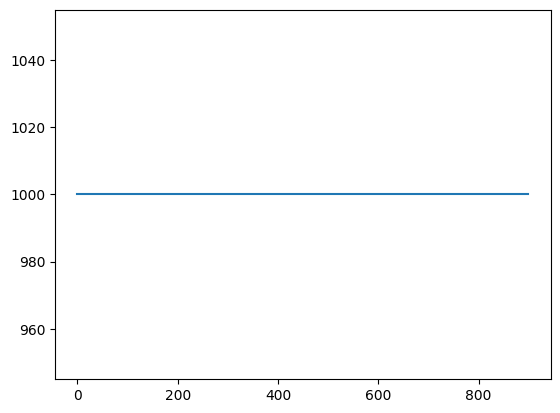

In [4]:
# Проверка, что матрица соответствует требованиям
check_generate_matrix(generate_random_matrix_simple)

### Генерация квадратичной функции (на основе диагональной матрицы)

In [5]:
def generate_quadratic_function_simple(n, k):
    # Генерируем случайную матрицу размера n x n, и числом обусловленности k
    v = generate_random_vector_simple(n, k)

    # Определяем квадратичную функцию f(x) = x * A * x^T
    def f(x):
        return sum([v[i]*(x[i]**2) for i in range(len(v))])
    
    return f

### Генерация кода на Python квадратичной функции (на основе диагональной матрицы)

In [6]:
def get_str_equation_quadratic_function_simple():
    global v
    # Создаем список из строк для каждого члена квадратичной функции
    return [f'{v[i]}*x[{i}]**2' for i in range(len(v))]

def get_code_quadratic_function_simple():
    # Создаем список из строк для каждого члена квадратичной функции
    members = get_str_equation_quadratic_function_simple()

    # Объединяем строки с помощью символа '+'
    function_str = ' + '.join(members)

    # Создаем строку, содержащую полный код функции
    function_code = f'def f(x):\n\treturn {function_str}'

    return function_code

## Прогрессивный способ, сохраняет все коэффициенты квадратичного уравнения

### Поиск x, такой, что f(x) = m

In [7]:
def find_x(f, m, x1 = 0, x2 = 1):
    """
        Функция вычисления неизвестной x, такой, что f(x) = m

        Аргументы:
        f -- функция
        m -- необходимое значение
        x1, x2 -- точки, с которых начинаем поиск

        Возвращает:
        x -- неизвестная
    """
    # Используем метод бисекции для нахождения x
    eps = 1e-6
    while f(x2) < m:
        x1, x2 = x2, x2 * 2
    # Применяем метод бисекции
    while abs(x2 - x1) > eps:
        mid = (x1 + x2) / 2
        if f(mid) < m:
            x1 = mid
        else:
            x2 = mid
    return x2

### Генерация случайной матрицы размера $n$ и числом обусловленности $k$

In [8]:
def generate_random_matrix_progressive(n, k, eps=1e-3):
    # генерируем случайную матрицу размера n, и значениями в отрезке [-1, 1]
    A = np.random.uniform(low=-1, high=1, size=(n, n))

    for i in range(n):
        for j in range(n):
            # задаем позицию рассматриваемого элемента матрицы
            pos = i, j

            # задаем функцию возвращающую число обусловленности матрицы в зависимости от элемента матрицы
            def f(x):
                A[pos] = x
                return np.linalg.cond(A)

            buf = A[pos]
            # ищем подходящий первый элемент матрицы
            A[pos] = find_x(f, k)

            # если не нашли, пробуем значения меньше нуля 
            if np.abs(np.linalg.cond(A) - k) > eps:
                A[pos] = find_x(f, k, x2=-1)
            else:
                return A
            
            A[pos] = buf


    # если и так не нашли, генерируем новую матрицу 
    if(np.abs(np.linalg.cond(A) - k) > 1e-3):
        return generate_random_matrix_progressive(n, k)

    return A

### Смотрим на график функции возвращающей число обусловленности матрицы в зависимости от элемента матрицы

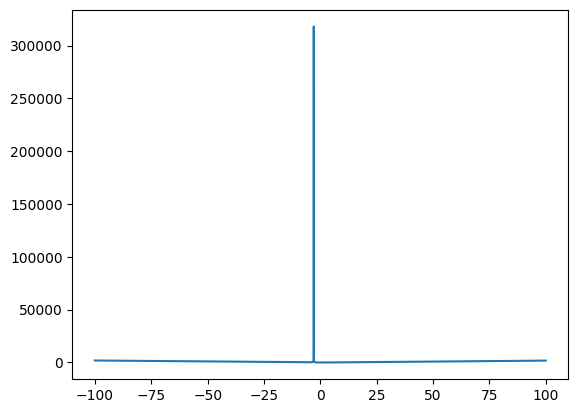

In [9]:
def show_f_cond():
    n = 2
    pos = 0,0 
    A = np.random.uniform(low=-1, high=1, size=(n, n))

    def f(x):
        A[pos] = x
        return np.linalg.cond(A)
    
    x = np.arange(-100, 100, 0.01)
    y = np.vectorize(lambda x: f(x))(x)
    plt.plot(x, y)
    plt.show()

show_f_cond()

При анализе функции было замечено, что в районе нуля функция резко возрастает, причем, чем меньше мы берем шаг - тем больше получаются значения, из чего и появилась идея о поиске подходящего x в районе нуля

### Проверка рабоспособности $generate\_random\_matrix(n, k)$

<!-- ### Проверка рабоспособности $\verb|generate_random_matrix|(n, k)$ -->

100%|██████████| 900/900 [00:03<00:00, 292.54it/s]


Количество неправильных матриц: 0


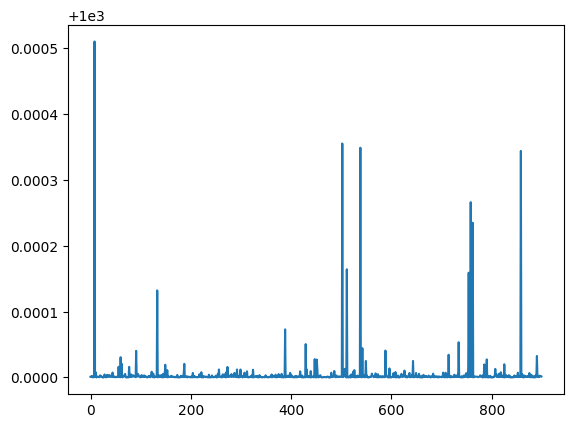

In [10]:
check_generate_matrix(generate_random_matrix_progressive)

### Генерация квадратичной функции (на основе полной матрицы)

In [11]:
def generate_quadratic_function_progressive(n, k):
    # Генерируем случайную матрицу размера n x n, и числом обусловленности k
    
    global A
    A = generate_random_matrix_progressive(n, k)

    # Определяем квадратичную функцию f(x) = x * A * x^T
    def f(x):
        return (x.dot(A)).dot(x.T) 
    
    return f

### Генерация кода на Python квадратичной функции (на основе полной матрицы)

In [12]:
def get_str_equation_quadratic_function_progressive():
    global A
    # Формируем строку, соответствующую уравнению квадратичной функции
    x_str = ['x[' + str(i) + ']' for i in range(A.shape[0])]
    terms = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            term = str(A[i][j]) + '*' + x_str[i] + '*' + x_str[j]
            terms.append(term)
    return ' + '.join(terms)      

def get_code_line_wiev_quadratic_function_progressive():
    return 'def f(x):\n\treturn ' + get_str_equation_quadratic_function_progressive()

def get_code_quadratic_function_progressive():
    global A
    # Преобразуем матрицу в список строк и добавляем символ переноса строки после каждой строки
    # A_str = '[' + ',\n '.join(['[' + ', '.join([str(e) for e in row]) + ']' for row in A]) + ']'
    A_str = str(A.tolist())
    function_code = 'def quadratic_function(x):\n'
    function_code += f'\tA = np.array({A_str})\n'
    function_code += '\treturn (x.dot(A)).dot(x.T)'
    return function_code

# TEST

In [13]:
def init():
    global X, Y, Z, f, x0
    Z = np.vectorize(lambda x, y: f(np.array([x, y])))(X, Y)

In [14]:
%matplotlib inline
plt.style.use('fivethirtyeight')

def print_f(elev = 30, azim = 60):
  plt.figure(figsize=(10, 10))
  ax = plt.subplot(111, projection='3d')
  ax.view_init(elev=35, azim=45)

  ax.plot_surface(X, Y, Z)
  plt.plot(x0[0], x0[1], f(x0), 'ro', label='Начальная точка')
  ax.view_init(elev=elev, azim=azim)
  plt.legend(loc='upper left')
  plt.show()

def f(x):
	return 0.4252851626414269*x[0]**2 + 0.21264258132071345*x[1]**2


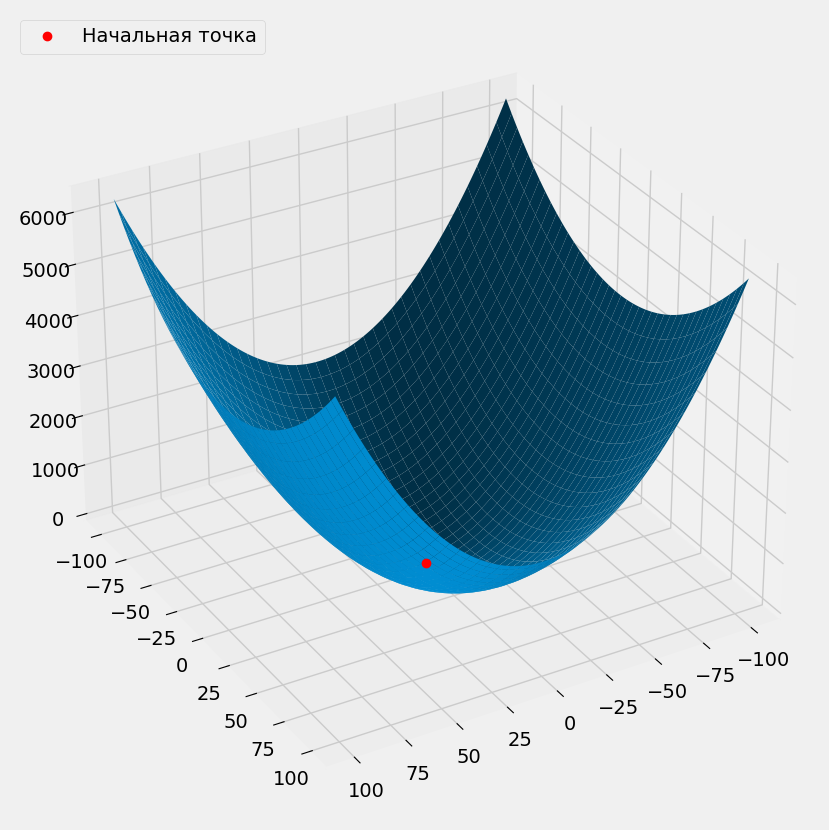

In [15]:
f = generate_quadratic_function_simple(2, 2)

x = np.linspace(-100, 100, 120)
y = np.linspace(-100, 100, 120)
X, Y = np.meshgrid(x, y)

x0 = np.array([0, 0], dtype=float)

init()

print(get_code_quadratic_function_simple())
print_f()

def quadratic_function(x):
	A = np.array([[1.0648412704467773, 0.733483364913353], [0.4213676093187435, -0.4974277371659457]])
	return (x.dot(A)).dot(x.T)


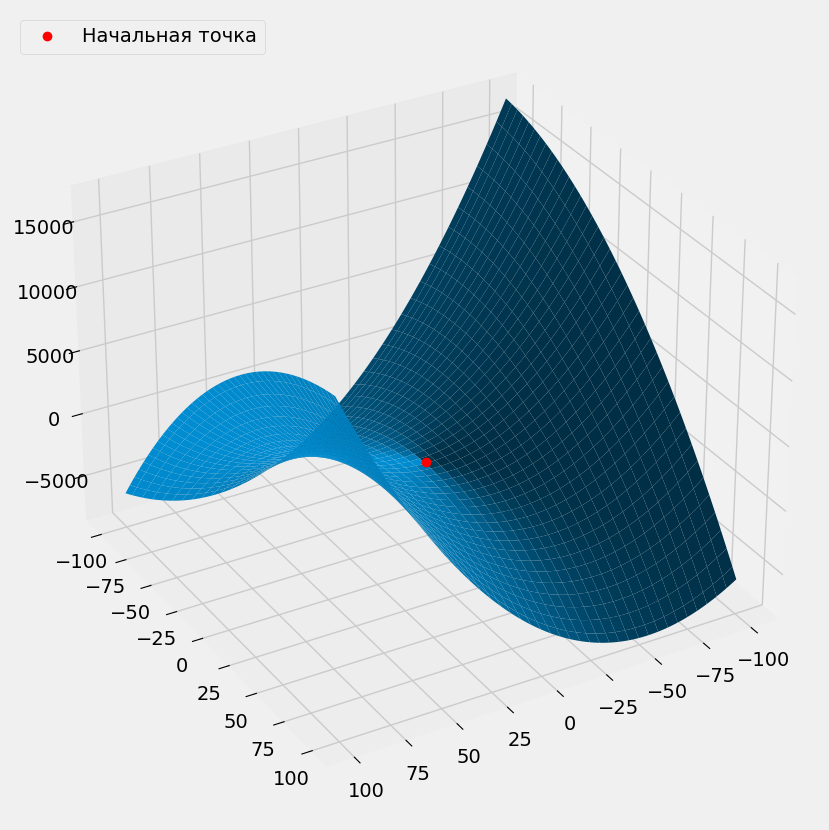

In [16]:
f = generate_quadratic_function_progressive(2, 2)

x = np.linspace(-100, 100, 120)
y = np.linspace(-100, 100, 120)
X, Y = np.meshgrid(x, y)

x0 = np.array([0, 0], dtype=float)

init()

print(get_code_quadratic_function_progressive())
print_f()